# Import Needed Libs and Load data

In [36]:
import nltk
import re
import pandas as pd
import numpy as np
import seaborn as sns
from nltk.corpus import stopwords
from collections import Counter
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from nltk.corpus import wordnet
import emoji
import matplotlib.pyplot as plt
from nltk.util import ngrams
import matplotlib
import contractions
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from typing import Tuple
from typing import List


In [ ]:
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet')
nltk.download('stopwords')

STOP_WORDS = set(stopwords.words('english'))
WNL = WordNetLemmatizer()

[nltk_data] Downloading package punkt to /home/johann/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /home/johann/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.
[nltk_data] Downloading package wordnet to /home/johann/nltk_data...
[nltk_data] Downloading package stopwords to /home/johann/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


: 

: 

In [37]:
df = pd.read_csv("../data/raw/mbti_1.csv")

In [38]:
# Split the data first to avoid data leakage
train_df, test_df = train_test_split(
    df, 
    test_size=0.2, 
    random_state=42, 
    stratify=df['type']
)
print(f"Train size: {len(train_df)}, Test size: {len(test_df)}")

Train size: 6940, Test size: 1735


# Data Preprocessing

In [39]:
df.describe()

,type,posts
count,8675,8675
unique,16,8675
top,INFP,'http://www.youtube.com/watch?v=qsXHcwe3krw|||...
freq,1832,1


In [40]:
df.posts[0]

"'http://www.youtube.com/watch?v=qsXHcwe3krw|||http://41.media.tumblr.com/tumblr_lfouy03PMA1qa1rooo1_500.jpg|||enfp and intj moments  https://www.youtube.com/watch?v=iz7lE1g4XM4  sportscenter not top ten plays  https://www.youtube.com/watch?v=uCdfze1etec  pranks|||What has been the most life-changing experience in your life?|||http://www.youtube.com/watch?v=vXZeYwwRDw8   http://www.youtube.com/watch?v=u8ejam5DP3E  On repeat for most of today.|||May the PerC Experience immerse you.|||The last thing my INFJ friend posted on his facebook before committing suicide the next day. Rest in peace~   http://vimeo.com/22842206|||Hello ENFJ7. Sorry to hear of your distress. It's only natural for a relationship to not be perfection all the time in every moment of existence. Try to figure the hard times as times of growth, as...|||84389  84390  http://wallpaperpassion.com/upload/23700/friendship-boy-and-girl-wallpaper.jpg  http://assets.dornob.com/wp-content/uploads/2010/04/round-home-design.jpg ...

In [41]:
def clean_text(text: str) -> str:
    """Clean raw text by removing URLs, emojis, mentions, and MBTI codes."""
    text = text.lower()
    text = re.sub(r'https?\S+|www\S+', '', text)
    text = emoji.replace_emoji(text, replace='')
    text = re.sub(r'@\w+|#', '', text)
    text = re.sub(r"[^a-z\']", ' ', text)
    # Remove MBTI type codes (e.g., INFJ, ENTP) to avoid leaking information
    text = re.sub(r'\b(I|E)(N|S)(F|T)(J|P)(s?)\b', '', text, flags=re.IGNORECASE)
    # Remove common footer
    text = re.sub(r'\bsent (from )?my \w+(\s\w+)? using tapatalk\b', '', text, flags=re.IGNORECASE)
    text = re.sub(r'w w w', '', text)
    text = re.sub(r'\s+', ' ', text).strip()
    return text

In [42]:
def preprocess_posts(posts_str: str) -> str:
    """Split multi-post string (separated by '|||'), clean each, and join."""
    posts = posts_str.split('|||')
    cleaned_posts = [clean_text(post) for post in posts]
    joined = ' '.join(cleaned_posts)
    return re.sub(r'\s+', ' ', joined).strip()

In [43]:

print("Cleaning posts for train...")
tqdm.pandas()
train_df['cleaned_posts'] = train_df['posts'].progress_apply(preprocess_posts)

print("Cleaning posts for test...")
test_df['cleaned_posts'] = test_df['posts'].progress_apply(preprocess_posts)

Cleaning posts for train...


100%|██████████| 6940/6940 [01:04<00:00, 107.02it/s]


Cleaning posts for test...


100%|██████████| 1735/1735 [00:16<00:00, 108.25it/s]


In [44]:


def encode_mbti_type(mbti: str) -> Tuple[int, int, int, int]:
    """
    Encode MBTI type as 4 binary dimensions:
    I/E → 1/0, N/S → 1/0, F/T → 1/0, J/P → 1/0
    """
    return (
        1 if mbti[0] == 'I' else 0,
        1 if mbti[1] == 'N' else 0,
        1 if mbti[2] == 'F' else 0,
        1 if mbti[3] == 'J' else 0,
    )

In [45]:
# Encode labels for train and test
print("Encoding MBTI types for train...")
train_df[['IE', 'NS', 'FT', 'JP']] = pd.DataFrame(
    train_df['type'].progress_apply(encode_mbti_type).tolist(),
    index=train_df.index
)

print("Encoding MBTI types for test...")
test_df[['IE', 'NS', 'FT', 'JP']] = pd.DataFrame(
    test_df['type'].progress_apply(encode_mbti_type).tolist(),
    index=test_df.index
)

Encoding MBTI types for train...


100%|██████████| 6940/6940 [00:00<00:00, 124843.86it/s]


Encoding MBTI types for test...


100%|██████████| 1735/1735 [00:00<00:00, 352164.03it/s]


_______________

In [46]:
nltk.download('punkt')
nltk.download('punkt_tab')
nltk.download('wordnet')
nltk.download('omw-1.4')
nltk.download('averaged_perceptron_tagger')
nltk.download('averaged_perceptron_tagger_eng')

def get_wordnet_pos(tag: str) -> str:
    """Map POS tag to WordNet format for lemmatization."""
    if tag.startswith('J'):
        return wordnet.ADJ
    elif tag.startswith('V'):
        return wordnet.VERB
    elif tag.startswith('N'):
        return wordnet.NOUN
    elif tag.startswith('R'):
        return wordnet.ADV
    else:
        return wordnet.NOUN

def tokenize_text(text: str) -> List[str]:
    """Expand contractions, tokenize, remove stopwords, and lemmatize."""
    fixed = contractions.fix(text)
    tokens = word_tokenize(fixed)
    filtered_tokens = [word for word in tokens if word.lower() not in STOP_WORDS]
    pos_tags = nltk.pos_tag(filtered_tokens)
    lemmatized = [
        WNL.lemmatize(token, pos=get_wordnet_pos(pos))
        for token, pos in pos_tags
    ]
    return lemmatized

tqdm.pandas()


print("Tokenizing and lemmatizing for train...")
train_df['tokens'] = train_df['cleaned_posts'].progress_apply(tokenize_text)

print("Tokenizing and lemmatizing for test...")
test_df['tokens'] = test_df['cleaned_posts'].progress_apply(tokenize_text)

[nltk_data] Downloading package punkt to /home/johann/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to /home/johann/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package wordnet to /home/johann/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /home/johann/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /home/johann/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package averaged_perceptron_tagger_eng to
[nltk_data]     /home/johann/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger_eng is already up-to-
[nltk_data]       date!


Tokenizing and lemmatizing for train...


  0%|          | 0/6940 [00:00<?, ?it/s]

100%|██████████| 6940/6940 [04:40<00:00, 24.74it/s]


Tokenizing and lemmatizing for test...


100%|██████████| 1735/1735 [01:10<00:00, 24.47it/s]


In [47]:
train_df.head()

,type,posts,cleaned_posts,IE,NS,FT,JP,tokens
8331,INFP,'this is actually exactly what i expected! :l...,'this is actually exactly what i expected laug...,1,1,1,0,"['this, actually, exactly, expect, laugh, intr..."
1290,ISTP,"'Nope. Not now, not ever. I'm too busy with ...",'nope not now not ever i'm too busy with work ...,1,0,0,0,"['nope, ever, busy, work, cause, adrenaline, r..."
1982,ENFJ,'Yes peace is the absence of conflict - your I...,'yes peace is the absence of conflict your fri...,0,1,1,1,"['yes, peace, absence, conflict, friend, suxx,..."
769,INFP,"'I apologize for the delayed response, but tha...",'i apologize for the delayed response but than...,1,1,1,0,"[', apologize, delay, response, thank, taking,..."
8339,INFP,"'Nightglow, I can't even imagine what you must...",'nightglow i can't even imagine what you must ...,1,1,1,0,"['nightglow, even, imagine, must, struggle, ri..."


In [48]:
def generate_ngrams(tokens: List[str]) -> Tuple[List, List, List]:
    """Generate unigrams, bigrams, and trigrams from token list."""
    unigrams = list(ngrams(tokens, 1))
    bigrams = list(ngrams(tokens, 2))
    trigrams = list(ngrams(tokens, 3))
    return unigrams, bigrams, trigrams

In [49]:
# Generate n-grams for train and test
print("📊 Generating n-grams for train...")
ngram_results_train = train_df['tokens'].progress_apply(generate_ngrams)
train_df[['Unigrams', 'Bigrams', 'Trigrams']] = pd.DataFrame(
    ngram_results_train.tolist(), index=train_df.index
)

print("📊 Generating n-grams for test...")
ngram_results_test = test_df['tokens'].progress_apply(generate_ngrams)
test_df[['Unigrams', 'Bigrams', 'Trigrams']] = pd.DataFrame(
    ngram_results_test.tolist(), index=test_df.index
)

📊 Generating n-grams for train...


100%|██████████| 6940/6940 [00:04<00:00, 1567.92it/s]


📊 Generating n-grams for test...


100%|██████████| 1735/1735 [00:01<00:00, 1067.53it/s]


In [50]:
# Word count stats (on train for EDA)
train_df['word_count'] = train_df['tokens'].apply(len)
print("Word Count Statistics (Train):")
print(train_df['word_count'].describe())

Word Count Statistics (Train):
count    6940.000000
mean      595.601441
std       139.623337
min         1.000000
25%       517.000000
50%       620.000000
75%       699.000000
max       906.000000
Name: word_count, dtype: float64


In [51]:
train_df.head()

,type,posts,cleaned_posts,IE,NS,FT,JP,tokens,Unigrams,Bigrams,Trigrams,word_count
8331,INFP,'this is actually exactly what i expected! :l...,'this is actually exactly what i expected laug...,1,1,1,0,"['this, actually, exactly, expect, laugh, intr...","[('this,), (actually,), (exactly,), (expect,),...","[('this, actually), (actually, exactly), (exac...","[('this, actually, exactly), (actually, exactl...",722
1290,ISTP,"'Nope. Not now, not ever. I'm too busy with ...",'nope not now not ever i'm too busy with work ...,1,0,0,0,"['nope, ever, busy, work, cause, adrenaline, r...","[('nope,), (ever,), (busy,), (work,), (cause,)...","[('nope, ever), (ever, busy), (busy, work), (w...","[('nope, ever, busy), (ever, busy, work), (bus...",638
1982,ENFJ,'Yes peace is the absence of conflict - your I...,'yes peace is the absence of conflict your fri...,0,1,1,1,"['yes, peace, absence, conflict, friend, suxx,...","[('yes,), (peace,), (absence,), (conflict,), (...","[('yes, peace), (peace, absence), (absence, co...","[('yes, peace, absence), (peace, absence, conf...",578
769,INFP,"'I apologize for the delayed response, but tha...",'i apologize for the delayed response but than...,1,1,1,0,"[', apologize, delay, response, thank, taking,...","[(',), (apologize,), (delay,), (response,), (t...","[(', apologize), (apologize, delay), (delay, r...","[(', apologize, delay), (apologize, delay, res...",636
8339,INFP,"'Nightglow, I can't even imagine what you must...",'nightglow i can't even imagine what you must ...,1,1,1,0,"['nightglow, even, imagine, must, struggle, ri...","[('nightglow,), (even,), (imagine,), (must,), ...","[('nightglow, even), (even, imagine), (imagine...","[('nightglow, even, imagine), (even, imagine, ...",701


In [52]:
def analyze_class_distribution(df: pd.DataFrame):
    # 16 types
    type_counts = df['type'].value_counts()
    print("MBTI Type Distribution:\n", type_counts)
    
    # Dichotomies (using binary encodings)
    dichotomy_counts = {
        'I/E': df['IE'].value_counts(normalize=True) * 100,  # 1=I, 0=E
        'N/S': df['NS'].value_counts(normalize=True) * 100,  # 1=N, 0=S
        'F/T': df['FT'].value_counts(normalize=True) * 100,  # 1=F, 0=T
        'J/P': df['JP'].value_counts(normalize=True) * 100,  # 1=J, 0=P
    }
    print("Dichotomy Percentages:\n", pd.DataFrame(dichotomy_counts))
    
    # Plot 16 types
    plt.figure(figsize=(12, 6))
    sns.barplot(x=type_counts.index, y=type_counts.values)
    plt.title('MBTI Type Distribution')
    plt.xlabel('Type')
    plt.ylabel('Count')
    plt.xticks(rotation=45)
    plt.show()

MBTI Type Distribution:
 type
INFP    1466
INFJ    1176
INTP    1043
INTJ     873
ENTP     548
ENFP     540
ISTP     270
ISFP     217
ENTJ     185
ISTJ     164
ENFJ     152
ISFJ     133
ESTP      71
ESFP      38
ESFJ      33
ESTJ      31
Name: count, dtype: int64
Dichotomy Percentages:
          I/E        N/S        F/T        J/P
0  23.025937  13.789625  45.893372  60.417867
1  76.974063  86.210375  54.106628  39.582133


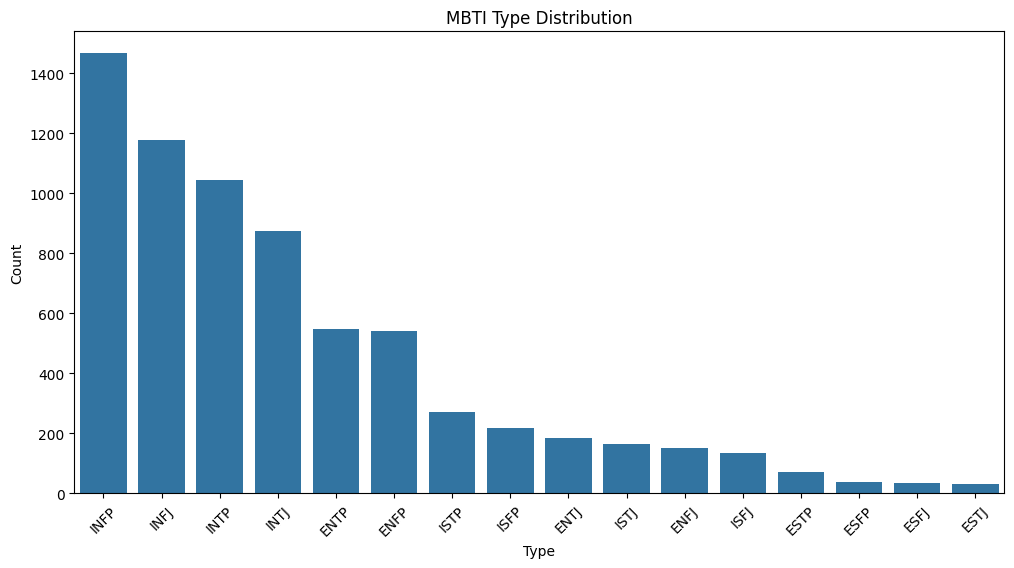

In [53]:
# Perform analysis on train set for EDA
analyze_class_distribution(train_df)

In [54]:
X_train = train_df['cleaned_posts']
X_test = test_df['cleaned_posts']
y_train = train_df[['IE', 'NS', 'FT', 'JP']]
y_test = test_df[['IE', 'NS', 'FT', 'JP']]
print(f"Train size: {len(X_train)}, Test size: {len(X_test)}")

Train size: 6940, Test size: 1735


1. Feature Engineering Strategy

In [55]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.pipeline import Pipeline
from sklearn.svm import LinearSVC
from sklearn.multioutput import MultiOutputClassifier
from sklearn.metrics import classification_report, accuracy_score
import numpy as np

def create_feature_combinations(X_train, X_test):
    """
    Create multiple feature combinations for experimentation
    """
    feature_sets = {}
    
    # Strategy 1: Unigrams only
    uni_vectorizer = TfidfVectorizer(
        max_features=10000,
        ngram_range=(1, 1),
        min_df=2,
        max_df=0.8,
        stop_words='english'
    )
    X_train_uni = uni_vectorizer.fit_transform(X_train)
    X_test_uni = uni_vectorizer.transform(X_test)
    feature_sets['unigrams'] = (X_train_uni, X_test_uni, uni_vectorizer)
    
    # Strategy 2: Unigrams + Bigrams
    uni_bi_vectorizer = TfidfVectorizer(
        max_features=15000,
        ngram_range=(1, 2),
        min_df=2,
        max_df=0.8,
        stop_words='english'
    )
    X_train_uni_bi = uni_bi_vectorizer.fit_transform(X_train)
    X_test_uni_bi = uni_bi_vectorizer.transform(X_test)
    feature_sets['unigrams_bigrams'] = (X_train_uni_bi, X_test_uni_bi, uni_bi_vectorizer)
    
    # Strategy 3: Unigrams + Bigrams + Trigrams
    full_vectorizer = TfidfVectorizer(
        max_features=20000,
        ngram_range=(1, 3),
        min_df=3,  # Higher min_df for trigrams
        max_df=0.8,
        stop_words='english'
    )
    X_train_full = full_vectorizer.fit_transform(X_train)
    X_test_full = full_vectorizer.transform(X_test)
    feature_sets['all_ngrams'] = (X_train_full, X_test_full, full_vectorizer)
    
    # Strategy 4: Character n-grams (captures stylistic patterns)
    char_vectorizer = TfidfVectorizer(
        max_features=5000,
        analyzer='char_wb',
        ngram_range=(3, 5),
        min_df=2
    )
    X_train_char = char_vectorizer.fit_transform(X_train)
    X_test_char = char_vectorizer.transform(X_test)
    feature_sets['char_ngrams'] = (X_train_char, X_test_char, char_vectorizer)
    
    return feature_sets

2. SVM Training Pipeline

In [56]:
from sklearn.model_selection import GridSearchCV
from sklearn.calibration import CalibratedClassifierCV
import scipy

def train_svm_models(X_train, y_train, feature_sets):
    """
    Train SVM models with different feature combinations and hyperparameter tuning
    """
    results = {}
    
    # Hyperparameter grid for SVM
    param_grid = {
        'estimator__C': [0.1, 1, 10, 100],
        'estimator__class_weight': [None, 'balanced']
    }
    
    for feature_name, (X_train_feat, X_test_feat, vectorizer) in feature_sets.items():
        print(f"\n=== Training with {feature_name} ===")
        
        # Feature selection for high-dimensional spaces
        if X_train_feat.shape[1] > 5000:
            selector = SelectKBest(chi2, k=min(5000, X_train_feat.shape[1]))
            X_train_selected = selector.fit_transform(X_train_feat, y_train.iloc[:, 0])
            X_test_selected = selector.transform(X_test_feat)
        else:
            X_train_selected = X_train_feat
            X_test_selected = X_test_feat
        
        # Create MultiOutput SVM pipeline
        base_svm = LinearSVC(
            random_state=42,
            max_iter=2000,
            dual=True  # Better for n_features > n_samples
        )
        
        multi_svm = MultiOutputClassifier(base_svm)
        
        # Grid search for hyperparameter tuning
        grid_search = GridSearchCV(
            multi_svm,
            param_grid,
            cv=3,
            scoring='accuracy',
            n_jobs=-1,
            verbose=1
        )
        
        # Train model
        grid_search.fit(X_train_selected, y_train)
        
        # Store results
        results[feature_name] = {
            'model': grid_search.best_estimator_,
            'vectorizer': vectorizer,
            'selector': selector if X_train_feat.shape[1] > 5000 else None,
            'best_params': grid_search.best_params_,
            'best_score': grid_search.best_score_,
            'feature_set': (X_train_selected, X_test_selected)
        }
        
        print(f"Best parameters: {grid_search.best_params_}")
        print(f"Best CV score: {grid_search.best_score_:.4f}")
    
    return results

3. Ensemble Strategy

In [57]:
from sklearn.ensemble import VotingClassifier
from sklearn.base import BaseEstimator, ClassifierMixin

class FeatureWeightedEnsemble(BaseEstimator, ClassifierMixin):
    """
    Custom ensemble that weights predictions based on feature set performance
    """
    def __init__(self, models, weights=None):
        self.models = models
        self.weights = weights if weights else [1/len(models)] * len(models)
    
    def fit(self, X, y):
        # Models are already trained
        return self
    
    def predict(self, X):
        predictions = []
        for (name, model_data), weight in zip(self.models.items(), self.weights):
            X_feat = model_data['feature_set'][1]  # Use test features
            pred = model_data['model'].predict(X_feat)
            predictions.append(pred * weight)
        
        # Weighted average
        weighted_avg = np.sum(predictions, axis=0) / np.sum(self.weights)
        return (weighted_avg > 0.5).astype(int)
    
    def predict_proba(self, X):
        # For models that support probability estimates
        probas = []
        for (name, model_data), weight in zip(self.models.items(), self.weights):
            X_feat = model_data['feature_set'][1]
            # For LinearSVC, you might need CalibratedClassifierCV for probabilities
            try:
                proba = model_data['model'].predict_proba(X_feat)
                probas.append(proba * weight)
            except:
                # Fallback to decision function
                decision = model_data['model'].decision_function(X_feat)
                proba = 1 / (1 + np.exp(-decision))
                probas.append(proba * weight)
        
        return np.sum(probas, axis=0) / np.sum(self.weights)

4. Complete Evaluation Framework

In [58]:
def evaluate_mbti_predictions(y_true, y_pred, dimension_names=['IE', 'NS', 'FT', 'JP']):
    """
    Comprehensive evaluation for MBTI prediction
    """
    results = {}
    
    # Overall accuracy
    overall_accuracy = accuracy_score(y_true, y_pred)
    results['overall_accuracy'] = overall_accuracy
    
    # Per-dimension accuracy
    dimension_accuracies = {}
    for i, dim in enumerate(dimension_names):
        dim_accuracy = accuracy_score(y_true.iloc[:, i], y_pred[:, i])
        dimension_accuracies[dim] = dim_accuracy
        print(f"{dim} Accuracy: {dim_accuracy:.4f}")
    
    results['dimension_accuracies'] = dimension_accuracies
    
    # Exact type match (all 4 dimensions correct)
    exact_matches = np.all(y_true.values == y_pred, axis=1)
    exact_match_rate = np.mean(exact_matches)
    results['exact_match_rate'] = exact_match_rate
    print(f"Exact Type Match Rate: {exact_match_rate:.4f}")
    
    # Partial matches (3 out of 4 dimensions correct)
    partial_matches_3 = np.sum(y_true.values == y_pred, axis=1) >= 3
    partial_match_3_rate = np.mean(partial_matches_3)
    results['partial_match_3_rate'] = partial_match_3_rate
    print(f"Partial Match (3/4) Rate: {partial_match_3_rate:.4f}")
    
    return results

def run_complete_evaluation():
    """
    Run the complete SVM evaluation pipeline
    """
    # 1. Create feature combinations
    print("Step 1: Creating feature combinations...")
    feature_sets = create_feature_combinations(X_train, X_test)
    
    # 2. Train SVM models
    print("\nStep 2: Training SVM models...")
    trained_models = train_svm_models(X_train, y_train, feature_sets)
    
    # 3. Evaluate individual models
    print("\nStep 3: Evaluating individual models...")
    individual_results = {}
    for feature_name, model_data in trained_models.items():
        print(f"\n--- Results for {feature_name} ---")
        X_test_feat = model_data['feature_set'][1]
        y_pred = model_data['model'].predict(X_test_feat)
        results = evaluate_mbti_predictions(y_test, y_pred)
        individual_results[feature_name] = results
    
    # 4. Create ensemble
    print("\nStep 4: Creating ensemble model...")
    # Weight models by their overall accuracy
    weights = [individual_results[name]['overall_accuracy'] for name in trained_models.keys()]
    ensemble = FeatureWeightedEnsemble(trained_models, weights)
    
    # 5. Evaluate ensemble
    print("\nStep 5: Evaluating ensemble model...")
    y_pred_ensemble = ensemble.predict(X_test)
    ensemble_results = evaluate_mbti_predictions(y_test, y_pred_ensemble)
    
    return {
        'individual_results': individual_results,
        'ensemble_results': ensemble_results,
        'trained_models': trained_models,
        'ensemble': ensemble
    }

5. Implementation and Analysis

In [59]:
# Run the complete evaluation
final_results = run_complete_evaluation()

# Feature importance analysis
def analyze_feature_importance(trained_models, top_n=20):
    """
    Analyze most important features for each MBTI dimension
    """
    for feature_name, model_data in trained_models.items():
        print(f"\n=== Top features for {feature_name} ===")
        
        vectorizer = model_data['vectorizer']
        selector = model_data['selector']
        model = model_data['model']
        
        # Get feature names after selection
        if selector:
            feature_names = vectorizer.get_feature_names_out()[selector.get_support()]
        else:
            feature_names = vectorizer.get_feature_names_out()
        
        # Analyze each dimension
        for i, dimension in enumerate(['IE', 'NS', 'FT', 'JP']):
            print(f"\n{dimension} dimension:")
            coef = model.estimators_[i].coef_[0]
            
            # Get top positive and negative features
            top_positive_idx = np.argsort(coef)[-top_n:][::-1]
            top_negative_idx = np.argsort(coef)[:top_n]
            
            print("Positive features:")
            for idx in top_positive_idx:
                if idx < len(feature_names):
                    print(f"  {feature_names[idx]}: {coef[idx]:.4f}")
            
            print("Negative features:")
            for idx in top_negative_idx:
                if idx < len(feature_names):
                    print(f"  {feature_names[idx]}: {coef[idx]:.4f}")

# Analyze feature importance
analyze_feature_importance(final_results['trained_models'])

Step 1: Creating feature combinations...

Step 2: Training SVM models...

=== Training with unigrams ===
Fitting 3 folds for each of 8 candidates, totalling 24 fits
Best parameters: {'estimator__C': 1, 'estimator__class_weight': None}
Best CV score: 0.3612

=== Training with unigrams_bigrams ===
Fitting 3 folds for each of 8 candidates, totalling 24 fits


/media/johann/CP/Python/notebooks/.venv/lib/python3.12/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/media/johann/CP/Python/notebooks/.venv/lib/python3.12/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/media/johann/CP/Python/notebooks/.venv/lib/python3.12/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


Best parameters: {'estimator__C': 1, 'estimator__class_weight': None}
Best CV score: 0.3755

=== Training with all_ngrams ===
Fitting 3 folds for each of 8 candidates, totalling 24 fits


/media/johann/CP/Python/notebooks/.venv/lib/python3.12/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/media/johann/CP/Python/notebooks/.venv/lib/python3.12/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/media/johann/CP/Python/notebooks/.venv/lib/python3.12/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/media/johann/CP/Python/notebooks/.venv/lib/python3.12/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


Best parameters: {'estimator__C': 1, 'estimator__class_weight': None}
Best CV score: 0.3769

=== Training with char_ngrams ===
Fitting 3 folds for each of 8 candidates, totalling 24 fits


/media/johann/CP/Python/notebooks/.venv/lib/python3.12/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/media/johann/CP/Python/notebooks/.venv/lib/python3.12/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/media/johann/CP/Python/notebooks/.venv/lib/python3.12/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/media/johann/CP/Python/notebooks/.venv/lib/python3.12/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/media/johann/CP/Python/notebooks/.venv/lib/python3.12/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/media/joh

Best parameters: {'estimator__C': 1, 'estimator__class_weight': None}
Best CV score: 0.3429

Step 3: Evaluating individual models...

--- Results for unigrams ---
IE Accuracy: 0.7925
NS Accuracy: 0.8565
FT Accuracy: 0.7539
JP Accuracy: 0.6605
Exact Type Match Rate: 0.3522
Partial Match (3/4) Rate: 0.7643

--- Results for unigrams_bigrams ---
IE Accuracy: 0.7850
NS Accuracy: 0.8646
FT Accuracy: 0.7545
JP Accuracy: 0.6818
Exact Type Match Rate: 0.3660
Partial Match (3/4) Rate: 0.7775

--- Results for all_ngrams ---
IE Accuracy: 0.7914
NS Accuracy: 0.8628
FT Accuracy: 0.7585
JP Accuracy: 0.6761
Exact Type Match Rate: 0.3620
Partial Match (3/4) Rate: 0.7839

--- Results for char_ngrams ---
IE Accuracy: 0.7902
NS Accuracy: 0.8622
FT Accuracy: 0.7735
JP Accuracy: 0.6634
Exact Type Match Rate: 0.3510
Partial Match (3/4) Rate: 0.7850

Step 4: Creating ensemble model...

Step 5: Evaluating ensemble model...
IE Accuracy: 0.7914
NS Accuracy: 0.8640
FT Accuracy: 0.7620
JP Accuracy: 0.6859
Exact Ty